I have been checking out the spacy nlp library and wanted to try some of it's abilities on this quora dataset. This notebook generates two new sets of features that might help your models. First, spacy tags the parts of speech in the texts it parses, which can be made into a sparse matrix and joined to the original dataframe. The second item is a similarity score between texts, I thought the 1-similarity number would be more intuitive so created a function around spacy's method. Hope this helps!


In [1]:
import pandas as pd
import spacy

In [3]:
train = pd.read_csv("./input/train.csv.zip")

In [ ]:
train.head(10)


In [4]:
train.shape

(404290, 6)

In [6]:
nlp = spacy.load("en")

In [7]:
question_list = []
for item in train['question1']:
    question_list.append(str(item))

#print(' '.join(question_list))    

In [8]:
test_mod = nlp(' '.join(question_list[0:10]))
type(test_mod)

spacy.tokens.doc.Doc

In [9]:
def pos_count(string):
    #counts parts of speech for each spacy document object
    parsed_string = nlp(string)
    pos_dict = {}
    
    for word in parsed_string:
        if word.pos_ in pos_dict:
            pos_dict[word.pos_] += 1
        else:    
            pos_dict[word.pos_] = 1
    return pos_dict    

In [10]:
print(train['question1'][3])
b = pos_count(train['question2'][3])
print(b)


Why am I mentally very lonely? How can I solve it?
{'ADV': 1, 'DET': 1, 'ADP': 1, 'PUNCT': 3, 'NOUN': 2, 'VERB': 3, 'NUM': 1}


In [11]:
pos_list = []
for item in train['question1'][0:4]:
    dict = pos_count(item)
    pos_list.append(dict)


In [79]:
pos_df = pd.DataFrame(pos_list)

pd.concat([train[0:4], pos_df], axis = 1)

,id,qid1,qid2,question1,question2,is_duplicate,ADJ,ADP,ADV,DET,NOUN,PART,PRON,PROPN,PUNCT,VERB
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,NaN,3.0,NaN,1.0,7.0,1.0,NaN,NaN,1,2
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,NaN,1.0,NaN,1.0,2.0,NaN,NaN,5.0,5,1
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1.0,2.0,1.0,2.0,3.0,NaN,1.0,1.0,1,3
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1.0,NaN,4.0,NaN,NaN,NaN,3.0,NaN,2,3


In [13]:
train[['question1', 'question2']].loc[0:10]

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan..."
6,Should I buy tiago?,What keeps childern active and far from phone ...
7,How can I be a good geologist?,What should I do to be a great geologist?
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?"
9,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?


In [14]:
nlp_list = []
questions = train[['question1', 'question2']][0:10]


In [15]:
def dis_similarity(question_pair):
    
    parsed1 = nlp(question_pair[0])
    parsed2 = nlp(question_pair[1])
    anti_sim = 1 - parsed1.similarity(parsed2)
    return anti_sim

In [16]:
len(questions)

10

In [23]:
sample_qs = train.sample(10000, random_state = 42)

In [24]:
sample_qs.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [25]:
sample_qs['dis'] = sample_qs[['question1','question2']].apply(dis_similarity, axis = 1)

In [26]:
sample_qs.head()

,id,qid1,qid2,question1,question2,is_duplicate,dis
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,0.008648
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,0.068459
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,0.170978
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,0.055018
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,0.111128


In [82]:
sample_qs.groupby('is_duplicate').describe()

dis             id    polarity1           qid1  \
is_duplicate                                                                  
0            count  6.265000e+03    6265.000000  6265.000000    6265.000000   
             mean   1.164964e-01  200618.425219     0.127289  245780.474860   
             std    7.531203e-02  116402.092921     0.312474  155251.339923   
             min   -1.059282e-07     123.000000    -1.000000      87.000000   
             25%    6.647940e-02  101432.000000     0.000000  107862.000000   
             50%    1.065744e-01  199543.000000     0.000000  238057.000000   
             75%    1.549666e-01  302048.000000     0.200000  374523.000000   
             max    1.000000e+00  404289.000000     1.000000  537932.000000   
1            count  3.735000e+03    3735.000000  3735.000000    3735.000000   
             mean   7.596537e-02  202311.231861     0.169028  164413.169210   
             std    4.573286e-02  116259.574361     0.362126  144952.728672   
             min   -1.127953e-07      85.000000    -1.000000      77.000000   
             25%    4.252045e-02   99254.000000     0.000000   41545.000000   
             50%    6.994835e-02  202784.000000     0.000000  120818.000000   
             75%    1.018706e-01  302756.500000     0.333333  257357.500000   
             max    4.332188e-01  403724.000000     1.000000  536689.000000   

                             qid2  subjectivity  subjectivity1  
is_duplicate                                                    
0            count    6265.000000   6265.000000    6265.000000  
             mean   248007.421069      0.250519       0.250519  
             std    157626.510904      0.292455       0.292455  
             min       232.000000      0.000000       0.000000  
             25%    105363.000000      0.000000       0.000000  
             50%    242962.000000      0.119048       0.119048  
             75%    381546.000000      0.500000       0.500000  
             max    537933.000000      1.000000       1.000000  
1            count    3735.000000   3735.000000    3735.000000  
             mean   165315.735743      0.244742       0.244742  
             std    146314.150100      0.286896       0.286896  
             min        38.000000      0.000000       0.000000  
             25%     41655.000000      0.000000       0.000000  
             50%    118148.000000      0.125000       0.125000  
             75%    264801.500000      0.450000       0.450000  
             max    536690.000000      1.000000       1.000000

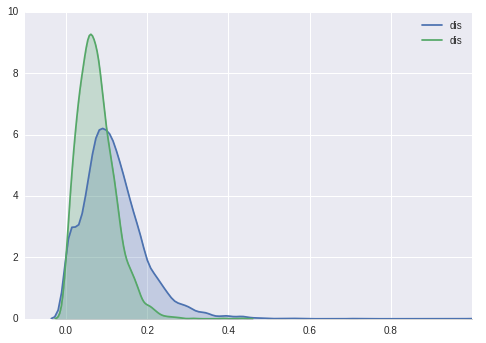

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for a in [sample_qs['dis'][sample_qs['is_duplicate']==0], sample_qs['dis'][sample_qs['is_duplicate']==1]]:
    sns.kdeplot(a,  ax=ax, shade = True)
ax.set_xlim([-0.1, 1])

#sns.kdeplot(sample_qs['dis'][sample_qs['is_duplicate']==0], shade = True)
#plt.show()

plt.show()

In [62]:
from textblob import TextBlob

def sentiment(question):
    
    pol_sub = [TextBlob(question).sentiment.polarity, 
               TextBlob(question).sentiment.subjectivity]
    return pol_sub           



[-0.15, 0.4]

In [67]:
question1_sent_subj = sample_qs['question1'].apply(sentiment)

In [75]:
sample_qs['polarity1'], sample_qs['subjectivity1'] = zip(*question1_sent_subj)

In [72]:
sample_qs.head()

,id,qid1,qid2,question1,question2,is_duplicate,dis,polarity1,subjectivity
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0,0.008648,0.00,0.00
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0,0.068459,1.00,0.30
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0,0.170978,0.50,0.50
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1,0.055018,0.25,0.25
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1,0.111128,0.00,0.00
